In [1]:
import pandas as pd 
import numpy as np
import requests
from matplotlib import pyplot as plt

# Targetome Processing 

We need to: 
1. Map the targetome drug names to broad identifiers. We will do this with INCHIKEYS and the clue repurposing dataset. 

In [2]:
## CONFIG 
THRESHOLD_uM = 10

In [3]:
targ = pd.read_csv('../../../data/targetome.txt', sep='\t')

targ = targ[lambda x: x.Assay_Relation == '=']
targ = targ[lambda x: x.Target_Type == 'Protein']
targ = targ[lambda x: x.Target_Species == 'Homo sapiens']
targ = targ[lambda x: x.EvidenceLevel_Assigned == 'III']

targ = targ.groupby(['Drug', 'Target_UniProt'])[['Assay_Value']].mean().reset_index()
targ = targ[lambda x: x.Assay_Value <= THRESHOLD_uM*1e3] # assume assay value is in nM 

targ.head()

,Drug,Target_UniProt,Assay_Value
0,Abiraterone Acetate,P05093,175.883333
1,Abiraterone Acetate,P08684,2702.666667
2,Abiraterone Acetate,P15538,1609.000000
3,Abiraterone Acetate,P19099,1750.333333
4,Afatinib Dimaleate,O14578,2900.000000


In [4]:
clue = pd.read_csv('../../../data/compoundinfo_beta.txt', sep='\t')
clue.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
0,BRD-A08715367,L-theanine,NaN,NaN,CCNC(=O)CCC(N)C(O)=O,DATAGRPVKZEWHA-UHFFFAOYSA-N,l-theanine
1,BRD-A12237696,L-citrulline,NaN,NaN,NC(CCCNC(N)=O)C(O)=O,RHGKLRLOHDJJDR-UHFFFAOYSA-N,l-citrulline
2,BRD-A18795974,BRD-A18795974,NaN,NaN,CCCN(CCC)C1CCc2ccc(O)cc2C1,BLYMJBIZMIGWFK-UHFFFAOYSA-N,7-hydroxy-DPAT
3,BRD-A27924917,BRD-A27924917,NaN,NaN,NCC(O)(CS(O)(=O)=O)c1ccc(Cl)cc1,WBSMZVIMANOCNX-UHFFFAOYSA-N,2-hydroxysaclofen
4,BRD-A35931254,BRD-A35931254,NaN,NaN,CN1CCc2cccc-3c2C1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-UHFFFAOYSA-N,r(-)-apomorphine


In [6]:
print('# of drugs:', len(targ['Drug'].unique()))
print('# of targets:', len(targ['Target_UniProt'].unique()))

# of drugs: 91
# of targets: 471


In [7]:

def get_smiles_inchikey(drug_name):
    """Retrieve the Canonical and Isomeric SMILES and InChIKey for a given drug name from PubChem."""
    properties = 'CanonicalSMILES,IsomericSMILES,InChIKey'
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{drug_name}/property/{properties}/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        try:
            props = data['PropertyTable']['Properties'][0]
            canonical_smiles = props.get('CanonicalSMILES', None)
            isomeric_smiles = props.get('IsomericSMILES', None)
            inchikey = props.get('InChIKey', None)
            return canonical_smiles, isomeric_smiles, inchikey
        except (KeyError, IndexError):
            return None, None, None
    else:
        return None, None, None

In [8]:

name2inchi = {'Drug':[], 'inchi_key':[]}
drugs = targ['Drug'].unique()
for i, drug in enumerate(drugs):
    print(f'progress: {i}/{len(drugs)}', end='\r')
    _, _, inchi_key = get_smiles_inchikey(drug)
    name2inchi['Drug'].append(drug)
    name2inchi['inchi_key'].append(inchi_key)
name2inchi = pd.DataFrame(name2inchi)

name2inchi = name2inchi.dropna()

name2inchi.head()

,Drug,inchi_key
0,Abiraterone Acetate,UVIQSJCZCSLXRZ-UBUQANBQSA-N
1,Afatinib Dimaleate,USNRYVNRPYXCSP-JUGPPOIOSA-N
2,Alectinib,KDGFLJKFZUIJMX-UHFFFAOYSA-N
3,Anastrozole,YBBLVLTVTVSKRW-UHFFFAOYSA-N
4,Aprepitant,ATALOFNDEOCMKK-OITMNORJSA-N


In [9]:
inchi2brd = clue[['pert_id', 'inchi_key']].drop_duplicates()

In [10]:
targ2 = pd.merge(targ, name2inchi, on='Drug', how='left').merge(inchi2brd, on='inchi_key', how='left').dropna()
targ2.head()

,Drug,Target_UniProt,Assay_Value,inchi_key,pert_id
0,Abiraterone Acetate,P05093,175.883333,UVIQSJCZCSLXRZ-UBUQANBQSA-N,BRD-K24048528
1,Abiraterone Acetate,P08684,2702.666667,UVIQSJCZCSLXRZ-UBUQANBQSA-N,BRD-K24048528
2,Abiraterone Acetate,P15538,1609.000000,UVIQSJCZCSLXRZ-UBUQANBQSA-N,BRD-K24048528
3,Abiraterone Acetate,P19099,1750.333333,UVIQSJCZCSLXRZ-UBUQANBQSA-N,BRD-K24048528
42,Alectinib,Q9UM73,1.900000,KDGFLJKFZUIJMX-UHFFFAOYSA-N,BRD-K11267252


In [11]:
print('# of drugs:', len(targ2['pert_id'].unique()))
print('# of targets:', len(targ2['Target_UniProt'].unique()))
print('# of interactions:', len(targ2))

# of drugs: 52
# of targets: 368
# of interactions: 839


In [12]:
targ2.to_csv('../../extdata/targetome_with_broad_ids.csv', index=False)

In [13]:
targ2.head()

,Drug,Target_UniProt,Assay_Value,inchi_key,pert_id
0,Abiraterone Acetate,P05093,175.883333,UVIQSJCZCSLXRZ-UBUQANBQSA-N,BRD-K24048528
1,Abiraterone Acetate,P08684,2702.666667,UVIQSJCZCSLXRZ-UBUQANBQSA-N,BRD-K24048528
2,Abiraterone Acetate,P15538,1609.000000,UVIQSJCZCSLXRZ-UBUQANBQSA-N,BRD-K24048528
3,Abiraterone Acetate,P19099,1750.333333,UVIQSJCZCSLXRZ-UBUQANBQSA-N,BRD-K24048528
42,Alectinib,Q9UM73,1.900000,KDGFLJKFZUIJMX-UHFFFAOYSA-N,BRD-K11267252


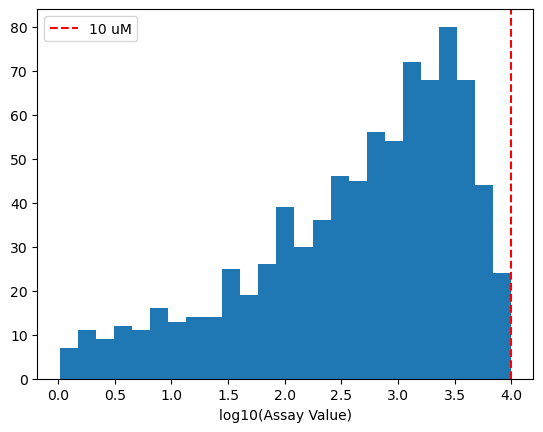

In [14]:
plt.figure()
plt.hist(np.log10(targ2['Assay_Value'] + 1), bins=25)
plt.xlabel('log10(Assay Value)')
plt.axvline(np.log10(10*1e3), color='r', linestyle='--', label='10 uM')
plt.legend()
plt.show()